In [1]:
 pip install nashpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nashpy: filename=nashpy-0.0.21-py3-none-any.whl size=15280 sha256=4f93e6da425f30af0501b3da84fd35c767bc86394f71a12c139939ea7170b226
  Stored in directory: /root/.cache/pip/wheels/02/08/62/cf4fa931e0a317d180936b266169a57f4bb4eb801465bbe8a1
Successfully built nashpy


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def factor(x):
    ans = 1
    while x > 1:
        ans *= x
        x -= 1
    return ans


In [4]:
class HospitalModel:
    def __init__(self, l, mu, n, N_lim, t_c):
        self._lambda = l
        self._mu = mu
        self._n = n
        self._N_lim = N_lim
        self._t_c = t_c

    def __ro(self, l: int, mu: int, n=None):
        return l / mu if n == None else l / mu / n

    def empty_queue(self, l, n):
        p = 1
        ro = self.__ro(l, self._mu)
        for j in range(1, n + 1):
            p += (ro ** j) / factor(j)
        add_ro = 0
        for j in range(n, self._N_lim):
            add_ro += (ro / n) ** j
        p += (ro ** n) / (factor(n) * add_ro - n)
        return p

    def k_in_queue(self, l, k, n):
        p_0 = self.empty_queue(l, n)
        ro = self.__ro(l, self._mu, n)
        return (ro ** k) * p_0

    def queue_length(self, l, n):
        p_0 = self.empty_queue(l, n)
        ro = self.__ro(l, self._mu, n)
        return (ro ** (n + 1)) / factor(n) * n / ((n - ro) ** 2) * p_0

    def queue_processing_time(self, l, n):
        L = self.queue_length(l, n)
        return L / l + 1 / self._mu

    def p_rej(self, l, n):
        p_0 = self.empty_queue(l, n)
        return  self.__ro(l, self._mu) ** self._N_lim / factor(n) / n ** (self._N_lim - n) * p_0

    def __lambda_rrrr_sup(self, l):
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]), 
                l[1] * self.p_rej(l[1], self._n[1]), 
                l[2] * self.p_rej(l[2], self._n[2]) , 
                l[3] * self.p_rej(l[3], self._n[3])] 
        l_r2 = [((l_r1[1] + l_r1[3])/2) * self.p_rej(l[0] + ((l_r1[1] + l_r1[3])/2), self._n[0]), 
                ((l_r1[0] + l_r1[2])/2) * self.p_rej(l[1] + ((l_r1[0] + l_r1[2])/2), self._n[1]), 
                ((l_r1[1] + l_r1[3])/2) * self.p_rej(l[2] + ((l_r1[1] + l_r1[3])/2), self._n[2]),
                ((l_r1[0] + l_r1[2])/2) * self.p_rej(l[3] + ((l_r1[0] + l_r1[2])/2), self._n[3])]

        l_r3 =  [(l_r2[2]) * self.p_rej(l[0] + ((l_r1[1] + l_r1[3])/2) + (l_r2[2]), self._n[0]),
                 (l_r2[3]) * self.p_rej(l[1] + ((l_r1[0] + l_r1[2])/2) + (l_r2[3]), self._n[1]), 
                 (l_r2[0]) * self.p_rej(l[2] + ((l_r1[1] + l_r1[3])/2) + (l_r2[0]), self._n[2]),
                 (l_r2[1]) * self.p_rej(l[3] + ((l_r1[0] + l_r1[2])/2) + (l_r2[1]), self._n[3])]
                
        l_i_1 = np.array([l[0] - l_r1[0], l[1] - l_r1[1], l[2] - l_r1[2],l[3] - l_r1[3]]) 
        l_i_2 = np.array([(l_r1[1] + l_r1[3])/2 - l_r2[0], (l_r1[0] + l_r1[2])/2 - l_r2[1],(l_r1[1] + l_r1[3])/2 - l_r2[2],(l_r1[2] + l_r1[0])/2 - l_r2[3] ]) 
        l_i_3 = np.array([l_r2[2]  - l_r3[0], l_r2[3] - l_r3[1], l_r2[0]- l_r3[2], l_r2[1]- l_r3[3]]) 
        l_i_4 = np.array([l_r3[0], l_r3[1], l_r3[2], l_r3[3]])
        return l_i_1, l_i_2, l_i_3, l_i_4 

    def __lambda_aarr_sup(self, l): 
        l_r1 = [ 0,0, l[2] * self.p_rej(l[2], self._n[2]), l[3] * self.p_rej(l[3], self._n[3])] 
        l_r2 = [0 ,0, (l[3]/2) * self.p_rej(l[2] + (l_r1[3]/2) , self._n[2]), (l[2]/2) * self.p_rej(l[3] + (l_r1[2]/2), self._n[3])]
        l_i_1 = np.array([l[0], l[1], l[2]- l_r1[2],  l[3]- l_r1[3]]) 
        l_i_2 = np.array([l_r1[3] /2 , l_r1[2] /2, (l_r1[3])/2 - l_r2[2], (l_r1[2])/2 - l_r2[3]]) 
        l_i_3 = np.array([l_r2[3],l_r2[2], 0,0]) 
        return  l_i_1, l_i_2, l_i_3

    def __lambda_rraa_sup(self, l): 
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]), l[1] * self.p_rej(l[1], self._n[1]), 0, 0] 
        l_r2 = [(l_r1[1]/2) * self.p_rej(l[0] + (l_r1[1]/2) , self._n[0]), (l_r1[0]/2) * self.p_rej(l[1] + (l_r1[0]/2), self._n[1]), 0 ,0]
        l_i_1 = np.array([ l[0]- l_r1[0],  l[1]- l_r1[1], l[2], l[3]]) 
        l_i_2 = np.array([(l_r1[1])/2 - l_r2[0], (l_r1[0])/2 - l_r2[1], l_r1[1] /2 , l_r1[0] /2]) 
        l_i_3 = np.array([0,0, l_r2[1],l_r2[0]]) 
        return  l_i_1, l_i_2, l_i_3

    def __lambda_arra_sup(self, l): 
        l_r1 = [0, l[1] * self.p_rej(l[1], self._n[1]), l[2] * self.p_rej(l[2], self._n[2]), 0] 
        l_r2 = [0, (l_r1[2]/2) * self.p_rej(l[1] + (l_r1[2]/2) , self._n[0]), (l_r1[1]/2) * self.p_rej(l[2] + (l_r1[1]/2), self._n[2]), 0]
        l_i_1 = np.array([ l[0],  l[1]- l_r1[1], l[2] - l_r1[2], l[3]]) 
        l_i_2 = np.array([l_r1[1] /2 , (l_r1[2])/2 - l_r2[1], (l_r1[1])/2 - l_r2[2], l_r1[2]/2]) 
        l_i_3 = np.array([l_r2[1], 0,0, l_r2[2]]) 
        return  l_i_1, l_i_2, l_i_3

    def __lambda_raar_sup(self, l): 
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]), 0,0, l[3] * self.p_rej(l[3], self._n[3])] 
        l_r2 = [(l_r1[3]/2) * self.p_rej(l[0] + (l_r1[3]/2), self._n[0]),0,0, (l_r1[0]/2) * self.p_rej(l[3] + (l_r1[0]/2), self._n[3])]
        l_i_1 = np.array([ l[0]- l_r1[0],  l[1], l[2], l[3]- l_r1[3]]) 
        l_i_2 = np.array([l_r1[3] /2 - l_r2[0], (l_r1[0])/2,  (l_r1[3])/2, l_r1[0]/2- l_r2[3]]) 
        l_i_3 = np.array([0,l_r2[0], l_r2[3],0]) 
        return  l_i_1, l_i_2, l_i_3

    def __lambda_raar_sup(self, l): 
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]), 0,0, l[3] * self.p_rej(l[3], self._n[3])] 
        l_r2 = [(l_r1[3]/2) * self.p_rej(l[0] + (l_r1[3]/2), self._n[0]),0,0, (l_r1[0]/2) * self.p_rej(l[3] + (l_r1[0]/2), self._n[3])]
        l_i_1 = np.array([ l[0]- l_r1[0],  l[1], l[2], l[3]- l_r1[3]]) 
        l_i_2 = np.array([l_r1[3] /2 - l_r2[0], (l_r1[0])/2,  (l_r1[3])/2, l_r1[0]/2- l_r2[3]]) 
        l_i_3 = np.array([0,l_r2[0], l_r2[3],0]) 
        return  l_i_1, l_i_2, l_i_3


    def __lambda_rrra_sup(self, l): 
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]),
                l[1] * self.p_rej(l[1], self._n[1]), 
                l[2] * self.p_rej(l[2], self._n[2]),
                0 ] 
        l_r2 = [((l_r1[1])/2) * self.p_rej(l[0] + ((l_r1[1])/2), self._n[0]),
                ((l_r1[0])/2 + (l_r1[2])/2) * self.p_rej(l[0] + (l_r1[0])/2 + (l_r1[2])/2, self._n[1]),
                ((l_r1[1])/2) * self.p_rej(l[2] + ((l_r1[1])/2), self._n[2]), 
                0 ]

        l_r3 = [l_r2[2] * self.p_rej(l[0] + ((l_r1[1])/2) + l_r2[2], self._n[0]),
                0,
                l_r2[0] * self.p_rej(l[2] + ((l_r1[1])/2) + l_r2[0], self._n[2]), 
                0 ] 

        l_i_1 = np.array([ l[0]- l_r1[0],  l[1]- l_r1[1], l[2]- l_r1[2], l[3]]) 
        l_i_2 = np.array([(l_r1[1])/2 - l_r2[0],
                          (l_r1[0])/2 + (l_r1[2])/2 - l_r2[0] ,  
                          (l_r1[1])/2  - l_r2[2], 
                          (l_r1[0])/2 + (l_r1[2])/2 - l_r2[3]]) 
        l_i_3 = np.array([l_r2[2] - l_r3[0],
                          0,
                          l_r2[0] - l_r3[2],
                          l_r2[1] - l_r3[3]]) 
        l_i_4 = np.array([ 0,0,0, l_r3[2]+l_r3[0]]) 
        return  l_i_1, l_i_2, l_i_3,  l_i_4


    def __lambda_rrar_sup(self, l): 
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]),
                l[1] * self.p_rej(l[1], self._n[1]), 
                0,
                l[3] * self.p_rej(l[3], self._n[3])] 

        l_r2 = [((l_r1[1])/2 + (l_r1[3])/2) * self.p_rej(l[0] + (l_r1[1])/2 + (l_r1[3])/2, self._n[0]),
                ((l_r1[0])/2) * self.p_rej(l[0] + (l_r1[0])/2, self._n[1]),
                0, 
                ((l_r1[0])/2) * self.p_rej(l[3] + (l_r1[0])/2, self._n[3])]

        l_r3 = [0,
                l_r2[3] * self.p_rej((l[0] + (l_r1[0])/2 + l_r2[3]), self._n[1]),
                0, 
                l_r2[1] * self.p_rej((l[3] + (l_r1[0])/2 + l_r2[1]), self._n[3]) ] 

        l_i_1 = np.array([ l[0]- l_r1[0],  l[1]- l_r1[1], l[2], l[3]- l_r1[3]]) 
        l_i_2 = np.array([(l_r1[1])/2 + (l_r1[3])/2 - l_r2[0],
                          (l_r1[0])/2 - l_r2[1] ,  
                          (l_r1[1])/2 + (l_r1[3])/2 - l_r2[2] , 
                          (l_r1[0])/2 - l_r2[3] ]) 
        l_i_3 = np.array([ 0 ,
                          l_r2[3] - l_r3[1],
                          l_r2[0],
                          l_r2[1] - l_r3[3]]) 
        l_i_4 = np.array([ 0,0, l_r3[1]+l_r3[3], 0]) 
        return  l_i_1, l_i_2, l_i_3,  l_i_4


    def __lambda_rarr_sup(self, l): 
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]),
                0, 
                l[2] * self.p_rej(l[2], self._n[2]),
                l[3] * self.p_rej(l[3], self._n[3])] 

        l_r2 = [
                ((l_r1[3])/2) * self.p_rej(l[0] + ((l_r1[3])/2), self._n[0]),
                0, 
                ((l_r1[3])/2)* self.p_rej(l[2] + ((l_r1[3])/2), self._n[2]),
                ((l_r1[0])/2 + (l_r1[2])/2) * self.p_rej((l[3] + (l_r1[0])/2 + (l_r1[2])/2), self._n[3])] 

        l_r3 = [l_r2[2] * self.p_rej(l[0] + ((l_r1[3])/2) + l_r2[2], self._n[0]),
                0,
                l_r2[0] * self.p_rej(l[0] + ((l_r1[3])/2) + l_r2[0], self._n[2]), 
                0 ]

        l_i_1 = np.array([ l[0]- l_r1[0],  l[1], l[2]- l_r1[2], l[3]- l_r1[3]]) 
        l_i_2 = np.array([
                          (l_r1[3])/2 - l_r2[0],
                          ((l_r1[0])/2 + (l_r1[2])/2)  - l_r2[1] ,  
                          (l_r1[3])/2 - l_r2[2] , 
                          ((l_r1[0])/2 + (l_r1[2])/2) - l_r2[3]]) 
        l_i_3 = np.array([ l_r2[2] - l_r3[0] ,
                          l_r2[3],
                          l_r2[0] - l_r3[2],
                         0])
        l_i_4 = np.array([ 0, l_r3[0]+l_r3[2], 0,0 ]) 
        return  l_i_1, l_i_2, l_i_3,  l_i_4


    def __lambda_arrr_sup(self, l): 
        l_r1 = [0,
                l[1] * self.p_rej(l[1], self._n[1]), 
                l[2] * self.p_rej(l[2], self._n[2]),
                l[3] * self.p_rej(l[3], self._n[3])] 

        l_r2 = [0,
                ((l_r1[2])/2)* self.p_rej(l[1] + (l_r1[2])/2, self._n[1]),
                ((l_r1[1])/2 + (l_r1[3])/2) * self.p_rej(l[3] + ((l_r1[1])/2 + (l_r1[3])/2), self._n[2]),
                ((l_r1[2])/2)* self.p_rej(l[3] + (l_r1[2])/2, self._n[3])] 

        l_r3 = [0,
                l_r2[3] * self.p_rej(l[1] + (l_r1[2])/2 + l_r2[3], self._n[1]),
                0, 
                l_r2[1] * self.p_rej(l[1] + (l_r1[2])/2 + l_r2[1], self._n[3]) ] 

        l_i_1 = np.array([ l[0],  l[1]- l_r1[1], l[2]- l_r1[2], l[3]- l_r1[3]]) 
        l_i_2 = np.array([((l_r1[1])/2 + (l_r1[3])/2),
                          (l_r1[2])/2 - l_r2[1],
                          ((l_r1[1])/2 + (l_r1[3])/2)  - l_r2[2],  
                          (l_r1[2])/2 - l_r2[3]])
        l_i_3 = np.array([ l_r2[2] ,
                          l_r2[3] - l_r3[1],
                          0,
                          l_r2[1] - l_r3[3]])
        l_i_4 = np.array([l_r3[1]+l_r3[3], 0,0,0 ])
        return  l_i_1, l_i_2, l_i_3,  l_i_4


    def lambdas(self, type):
        l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])

        if type == 'AAAA':
            return np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
        
        elif type == 'RAAA':
            return np.array([l[0] * (1 - self.p_rej(l[0], self._n[0])), 
                             l[1] + (l[0] * self.p_rej(l[0], self._n[0]))/2 ,
                             l[2],
                             l[3] + (l[0] * self.p_rej(l[0], self._n[0]))/2])
        elif type == 'ARAA': 
            return np.array([l[0] + (l[1] * self.p_rej(l[1], self._n[1]))/2, 
                             l[1] * (1 - self.p_rej(l[1], self._n[1])),
                             l[2] + (l[1] * self.p_rej(l[1], self._n[1]))/2,
                             l[3]])
        elif type == 'AARA': 
            return np.array([
                             l[0], 
                             l[1] + (l[2] * self.p_rej(l[2], self._n[2]))/2,
                             l[2] * (1 - self.p_rej(l[2], self._n[2])),
                             l[3] + (l[2] * self.p_rej(l[2], self._n[2]))/2])         
        elif type == 'AAAR':
            return np.array([
                             l[0] + (l[3] * self.p_rej(l[3], self._n[3]))/2, 
                             l[1],
                             l[2] + (l[3] * self.p_rej(l[3], self._n[3]))/2,
                             l[3] * (1 - self.p_rej(l[3], self._n[3]))
                             ])
        

        elif type == 'ARAR':
            return np.array([l[0] + (l[3] * self.p_rej(l[3], self._n[3]))/2 + l[1] * self.p_rej(l[1], self._n[1])/2 , 
                             l[1]* (1 - self.p_rej(l[1], self._n[1])),
                             l[2] + (l[3] * self.p_rej(l[3], self._n[3]))/2 + (l[1] * self.p_rej(l[1], self._n[1]))/2 ,
                             l[3] * (1 - self.p_rej(l[3], self._n[3]))])
        elif type == 'RARA':
            return np.array([l[0] * (1 - self.p_rej(l[0], self._n[0])), 
                             l[1] + (l[0] * self.p_rej(l[0], self._n[0]))/2 + (l[2] * self.p_rej(l[2], self._n[2]))/2 ,
                             l[2] * (1 - self.p_rej(l[2], self._n[2])) ,
                             l[3] + (l[0] * self.p_rej(l[0], self._n[0]))/2 + (l[2] * self.p_rej(l[2], self._n[2]))/2])
            
        elif type == 'AARR':
            return sum(self.__lambda_aarr_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))
        elif type == 'RRAA':
            return sum(self.__lambda_rraa_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))
        elif type == 'ARRA':
            return sum(self.__lambda_arra_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))
        elif type == 'RAAR':
            return sum(self.__lambda_raar_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))

        elif type == 'RRRA':
            return sum(self.__lambda_rrra_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))
        elif type == 'RRAR':
            return sum(self.__lambda_rrar_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))
        elif type == 'RARR':
            return sum(self.__lambda_rarr_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))
        elif type == 'ARRR':
            return sum(self.__lambda_arrr_sup(np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])))


        elif type == 'RRRR':
            return sum(self.__lambda_rrrr_sup(l))



    def t_transp(self, lambdas, type, i=None):
        if type == 'AAAA':
            return 0.5 * self._t_c
        if type == 'AAAR':
          l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          return np.array([
                          ((0.5*l[0] +(l[3] * self.p_rej(l[3], self._n[3]))/2)/l[0]),
                          0.5,
                          ((0.5*l[2] +(l[3] * self.p_rej(l[3], self._n[3]))/2)/l[2]) ,
                          0.5])[i]* self._t_c
        if type == 'AARA':
          l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          return np.array([
                          0.5,
                          ((0.5*l[1] +(l[2] * self.p_rej(l[2], self._n[2]))/2)/l[1]),
                          0.5 ,
                          ((0.5*l[3] +(l[2] * self.p_rej(l[2], self._n[2]))/2)/l[3])
          ])[i]* self._t_c
        if type == 'ARAA':
          l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          return np.array([
                          ((0.5*l[0] + (l[1] * self.p_rej(l[1], self._n[1]))/2)/l[0]),
                          0.5,
                          ((0.5*l[2] + (l[1] * self.p_rej(l[1], self._n[1]))/2)/l[2]) ,
                          0.5])[i]* self._t_c
        if type == 'RAAA':
          l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          return np.array([
                           0.5,
                          ((0.5*l[1] +(l[0] * self.p_rej(l[0], self._n[0]))/2)/l[1]),
                          0.5 ,
                          ((0.5*l[3] + (l[0] * self.p_rej(l[0], self._n[0]))/2)/l[3])
          ])[i]* self._t_c
        if type == 'ARAR' :
          l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          return np.array([
                        ((0.5*l[0] + (l[3] * self.p_rej(l[3], self._n[3]))/2) +(l[1] * self.p_rej(l[1], self._n[1]))/2) / (l[0] + (l[3] * self.p_rej(l[3], self._n[3]))/2 + (l[1] * self.p_rej(l[1], self._n[1]))/2),
                        0.5,
                        ((0.5*l[2] + (l[3] * self.p_rej(l[3], self._n[3]))/2) +(l[1] * self.p_rej(l[1], self._n[1]))/2) / (l[2] + (l[3] * self.p_rej(l[3], self._n[3]))/2 + (l[1] * self.p_rej(l[1], self._n[2]))/2),
                        0.5
          ])[i]* self._t_c
        if type == 'RARA' :
          l = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          return np.array([
                        0.5,
                        ((0.5*l[1] + (l[0] * self.p_rej(l[0], self._n[0]))/2) +(l[2] * self.p_rej(l[2], self._n[2]))/2) / (l[1] + (l[0] * self.p_rej(l[0], self._n[0]))/2 + (l[2] * self.p_rej(l[2], self._n[2]))/2),
                        0.5,
                        ((0.5*l[3] + (l[0] * self.p_rej(l[0], self._n[0]))/2) +(l[2] * self.p_rej(l[2], self._n[2]))/2) / (l[3] + (l[0] * self.p_rej(l[0], self._n[0]))/2 + (l[2] * self.p_rej(l[2], self._n[2]))/2)
          ])[i]* self._t_c

        if type == 'AARR':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3 = self.__lambda_aarr_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] + 0.5 * l_i_2[i] +  l_i_3[i]) / lambdas[i]
        if type == 'ARRA':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3 = self.__lambda_arra_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] + 0.5 * l_i_2[i] +  l_i_3[i]) / lambdas[i]
        if type == 'RRAA':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3 = self.__lambda_rraa_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] + 0.5 * l_i_2[i] +  l_i_3[i]) / lambdas[i]

        if type == 'RAAR':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3 = self.__lambda_raar_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] + 0.5 * l_i_2[i] +  l_i_3[i]) / lambdas[i]
        if type == 'RRRA':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3, l_i_4 = self.__lambda_rrra_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] + l_i_2[i] +  l_i_3[i] + l_i_4[i] ) / lambdas[i]
        if type == 'RRAR':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3, l_i_4 = self.__lambda_rrar_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] +  l_i_2[i] +  l_i_3[i] + l_i_4[i] ) / lambdas[i]
        if type == 'RARR':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3, l_i_4 = self.__lambda_rarr_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] +  l_i_2[i] +  l_i_3[i] + l_i_4[i] ) / lambdas[i]
        if type == 'ARRR':
          l_sup = np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3, l_i_4 = self.__lambda_arrr_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] +  l_i_2[i] +  l_i_3[i] + l_i_4[i] ) / lambdas[i]
        elif type == 'RRRR':
          l_sup =np.array([self._lambda / 4, self._lambda / 4, self._lambda / 4,  self._lambda / 4])
          l_i_1, l_i_2, l_i_3, l_i_4  = self.__lambda_rrrr_sup(l_sup)
          return self._t_c * (0.5 * l_i_1[i] + 1 * l_i_2[i] + 1* l_i_3[i] + 0.5 * l_i_4[i]) / lambdas[i]

    def total_time(self, lambdas, type):
        t_1 = self.queue_processing_time(lambdas[0], self._n[0])
        #print("t1" + str(t_1.shape))
        t_2 = self.queue_processing_time(lambdas[1], self._n[1])
        #print("t2" + str(t_2.shape))
        t_3 = self.queue_processing_time(lambdas[2], self._n[2])
        #print("t3" + str(t_3.shape))
        t_4 = self.queue_processing_time(lambdas[3], self._n[3])
        #print("t4" + str(t_4.shape))
        t_transp_1 = self.t_transp(lambdas, type, 0)
        #print("t_transp_1" + str(t_transp_1.shape))
        t_transp_2 = self.t_transp(lambdas, type, 1)
        #print("t_transp_2" + str(t_transp_2.shape))
        t_transp_3 = self.t_transp(lambdas, type, 2)
        #print("t_transp_3" + str(t_transp_3.shape))
        t_transp_4 = self.t_transp(lambdas, type, 3)
        #print("t_transp_4" + str(t_transp_4.shape))
        return np.array([t_1 + t_transp_1, t_2 + t_transp_2, t_3 + t_transp_3, t_4 + t_transp_4])

    def utility_function(self, l, t):
        return l / t

    def p_m(self, t):
        return 0.000043 * t ** 2 + 0.0045 * t 

    def utility_function_M1Y(self, l, t, r = 10, e = 0):
        return l*((1-self.p_m(t))*r - e)

    def utility_function_M1Y_high(self, l, t, r = 1000000, e = 0):
        return l*((1-self.p_m(t))*r - e)
    
    def global_average_time_function(self, l, t):
        return np.sum(l * t, 4) / np.sum(l, 4)

    def global_survival_rate(self):
      l, t = self.__lambdas_and_times()
      return np.sum( l*(1-self.p_m(t)), 4)/np.sum(l, 4)

    def survival_rate_M1Y(self, l,t):
        return l*(1-self.p_m(t))/l

    def __lambdas_and_times(self):
        lambdas = np.array([[[[self.lambdas('AAAA'), self.lambdas('AAAR')], [self.lambdas('AARA'), self.lambdas('AARR')]],
                            [[self.lambdas('ARAA'), self.lambdas('ARAR')], [self.lambdas('ARRA'), self.lambdas('ARRR')]]],
                           [[[self.lambdas('RAAA'), self.lambdas('RAAR')], [self.lambdas('RARA'), self.lambdas('RARR')]],
                            [[self.lambdas('RRAA'), self.lambdas('RRAR')], [self.lambdas('RRRA'), self.lambdas('RRRR')]]]])
        times = np.array(
            [[[[ self.total_time(lambdas[0][0][0][0], 'AAAA'), self.total_time(lambdas[0][0][0][1], 'AAAR')], [self.total_time(lambdas[0][0][1][0], 'AARA'), self.total_time(lambdas[0][0][1][1], 'AARR')]],
            [[self.total_time(lambdas[0][1][0][0], 'ARAA'), self.total_time(lambdas[0][1][0][1], 'ARAR')],[self.total_time(lambdas[0][1][1][0], 'ARRA'), self.total_time(lambdas[0][1][1][1], 'ARRR')]]],
            [[[ self.total_time(lambdas[1][0][0][0], 'RAAA'), self.total_time(lambdas[1][0][0][1], 'RAAR')], [self.total_time(lambdas[1][0][1][0], 'RARA'), self.total_time(lambdas[1][0][1][1], 'RARR')]],
            [[self.total_time(lambdas[1][1][0][0], 'RRAA'), self.total_time(lambdas[1][1][0][1], 'RRAR')],[self.total_time(lambdas[1][1][1][0], 'RRRA'), self.total_time(lambdas[1][1][1][1], 'RRRR')]]]])
        return lambdas, times
    
    def game_matrix(self):
        lambdas, times = self.__lambdas_and_times()
        return self.utility_function(lambdas, times)

    def game_matrix_M1Y(self):
        lambdas, times = self.__lambdas_and_times()
        return self.utility_function_M1Y(lambdas, times)

    def game_matrix_M1Y_high(self):
        lambdas, times = self.__lambdas_and_times()
        return self.utility_function_M1Y_high(lambdas, times)

    def get_lambdas(self):
      l, t = self.__lambdas_and_times()
      return l
    
    def global_average_time_matrix(self):
        lambdas, times = self.__lambdas_and_times()
        return self.global_average_time_function(lambdas, times)


In [5]:
#basic parameters
t_c = 0.5
N_lim = 5

In [6]:
def extract_player_utility(matrix, i):
    return np.array(matrix)[:, :, :,:, i]


def skip_mixed_strategy(eqs):
    return list(filter(lambda x: x[0][0][0][0] == 0 or x[0][0] == 1, eqs))


def extract_solution(eqs):
    solution = set()
    for eq in eqs:
        cur = 'A' if eq[0][0] == 1 else 'R'
        cur += 'A' if eq[1][0] == 1 else 'R'
        solution.add(cur)
    return ', '.join(solution)

def is_system_consistent(A, B, eqs):
    for eq in eqs:
        i = 0 if eq[0][0] == 1 else 1
        j = 0 if eq[1][0] == 1 else 1
        if A[i][j] < 0 or B[i][j] < 0:
            return False
    return True
#func
def is_equilibrium(matrix, strategies):
  num_players = len(strategies)
  for i in range (0, num_players):
    current_utility = matrix[tuple(strategies)][i]
    #print(current_utility)
    alt_strats = np.array(strategies)
    for j in range(0, matrix.shape[i]):
      alt_strats[i] = j
      if matrix[tuple(alt_strats)][i] > current_utility:
        return False
  return True

def number_to_letter(numbers):
  s = ''
  for i in numbers:
    if i == 0:
      s += 'A'
    else:
      s += 'R'
  return s
      

def find_solution(l, mu, n):
    hospital = HospitalModel(l, mu, n, N_lim, t_c)
    G = hospital.game_matrix()
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

def find_solution_M1Y(l, mu, n):
    hospital = HospitalModel(l, mu, n, N_lim, t_c)
    G = hospital.game_matrix_M1Y()
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

def find_solution_M1Y_high(l, mu, n):
    hospital = HospitalModel(l, mu, n, N_lim, t_c)
    G = hospital.game_matrix_M1Y_high()
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

In [7]:
def solution_plot(n, ax=None, legend=False):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution(l, mu, n))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax, legend=legend, s=100)
    if ax is not None:
        ax.set_title('N = ' + str(n))

In [8]:
def solution_plot_M1Y(n, ax=None, legend=False):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution_M1Y(l, mu, n))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax, legend=legend, s=100)
    if ax is not None:
        ax.set_title('N = ' + str(n))

In [9]:
def solution_plot_M1Y_high(n, ax=None, legend=False):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution_M1Y_high(l, mu, n))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax, legend=legend, s=100)
    if ax is not None:
        ax.set_title('N = ' + str(n))

In [10]:
def global_solution(l, mu, n):
    hospital = HospitalModel(l, mu, n, N_lim, t_c)
    G = hospital.global_average_time_matrix()
    solution = np.min(G)
    if solution < 0:
        return 'Inconsistent'
    if G[0][0][0][0] == solution:
        return 'AAAA'
    elif G[0][0][0][1]  == solution:
        return 'AAAR'
    elif G[0][0][1][0]  == solution:
        return 'AARA'
    elif G[0][1][0][0]  == solution:
        return 'ARAA'
    elif G[1][0][0][0]  == solution:
        return 'RAAA'
    elif G[0][0][1][1]  == solution:
        return 'AARR'
    elif G[0][1][1][1]  == solution:
        return 'ARRR'
    elif G[1][0][1][1]  == solution:
        return 'RARR'
    elif G[1][1][1][0]  == solution:
        return 'RRRA'
    elif G[1][1][0][1]  == solution:
        return 'ARAR'
    elif G[0][1][0][1]  == solution:
        return 'RARA'
    elif G[1][0][0][1]  == solution:
        return 'RAAR'
    elif G[1][1][0][0]  == solution:
        return 'RRAA'
    elif G[1][0][0][1]  == solution:
        return 'RAAR'
    elif G[0][0][1][1]  == solution:
        return 'AARR'
    elif G[0][0][1][0]  == solution:
        return 'AARA'
    elif G[0][0][1][0]  == solution:
        return 'AARA'
    else:
        return 'RRRR'

In [11]:
%matplotlib inline

def global_solution_plot(n, ax=None):
    data = {
        'Lambda': [],
        'Mu': [],
        'Optimal Strategy': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Optimal Strategy'].append(global_solution(l, mu, n))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Optimal Strategy', data=data, ax=ax, s=50)
    if ax is not None:
        ax.set_title('N = ' + str(n))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:406: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/di

CPU times: user 50.5 s, sys: 525 ms, total: 51.1 s
Wall time: 58.1 s


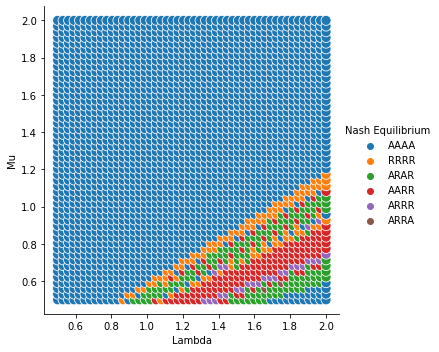

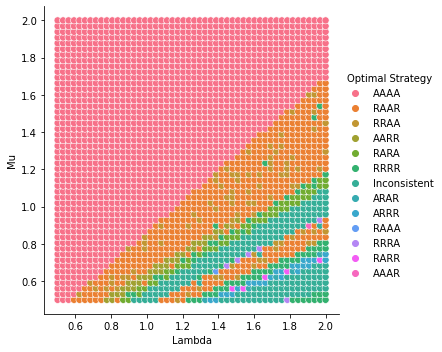

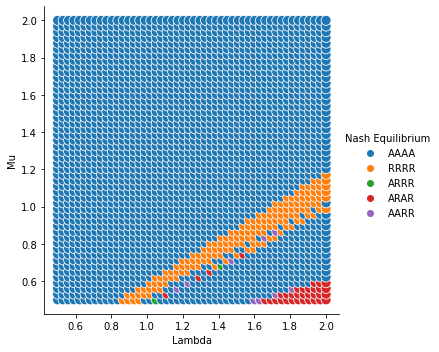

In [12]:
%%time
solution_plot([1,1,1,1], legend='brief')
global_solution_plot([1,1,1,1])
solution_plot_M1Y([1,1,1,1], legend='brief')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7

CPU times: user 38.6 s, sys: 526 ms, total: 39.2 s
Wall time: 38.8 s


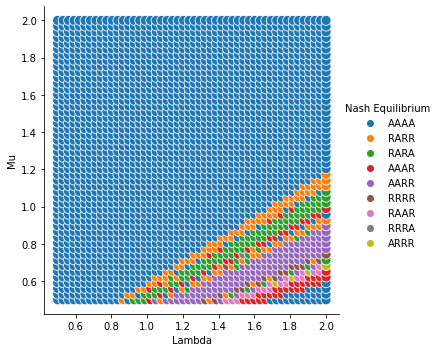

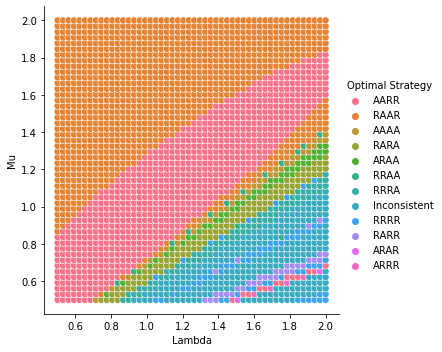

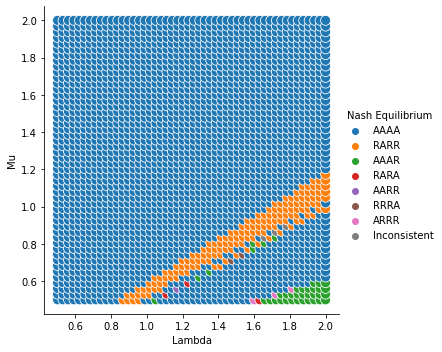

In [13]:
%%time
solution_plot([1,2,1,1], legend='brief')
global_solution_plot([1,2,1,1])
solution_plot_M1Y([1,2,1,1], legend='brief')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7

CPU times: user 39.6 s, sys: 591 ms, total: 40.2 s
Wall time: 40.7 s


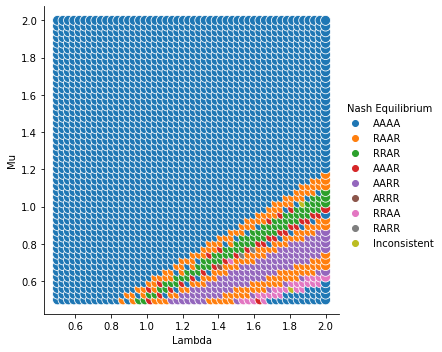

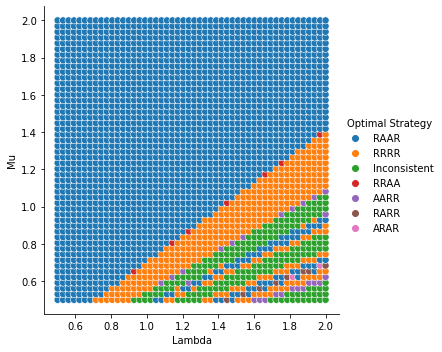

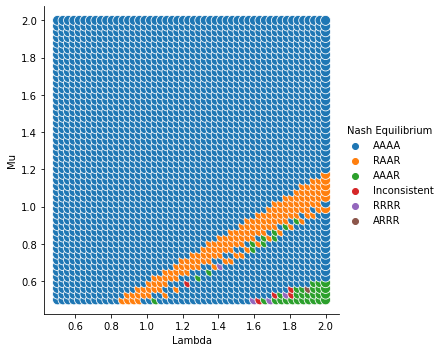

In [14]:
%%time
solution_plot([1,2,2,1], legend='brief')
global_solution_plot([1,2,2,1])
solution_plot_M1Y([1,2,2,1], legend='brief')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:406: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/d

CPU times: user 39.1 s, sys: 621 ms, total: 39.8 s
Wall time: 39.3 s


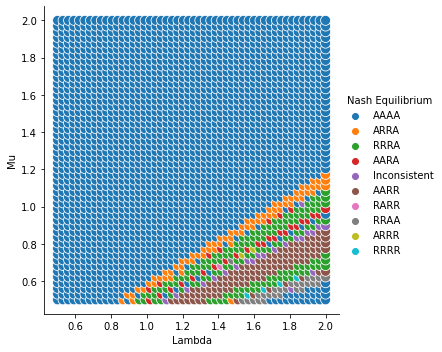

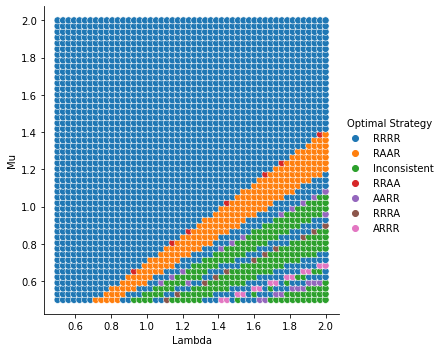

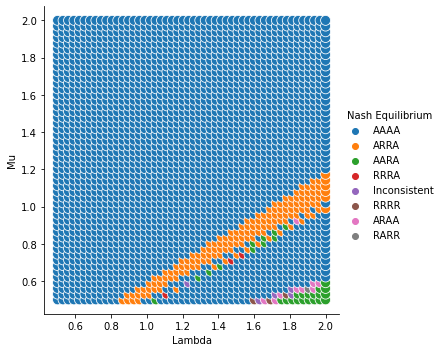

In [15]:
%%time
solution_plot([2,1,1,2], legend='brief')
global_solution_plot([2,1,1,2])
solution_plot_M1Y([2,1,1,2], legend='brief')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:406: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/d

CPU times: user 39.9 s, sys: 600 ms, total: 40.5 s
Wall time: 40 s


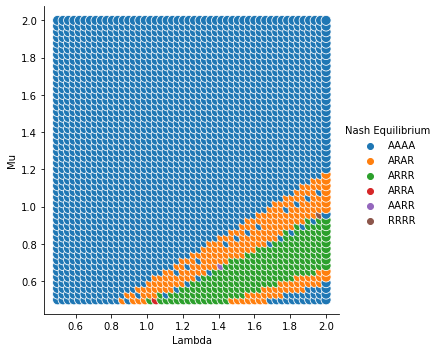

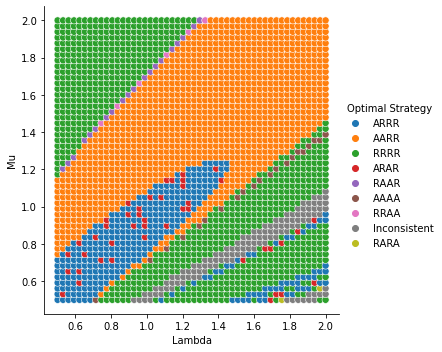

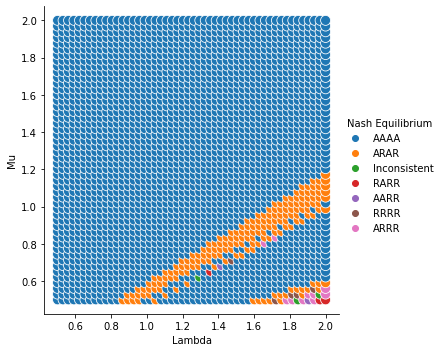

In [16]:
%%time
solution_plot([3,1,3,1], legend='brief')
global_solution_plot([3,1,3,1])
solution_plot_M1Y([3,1,3,1], legend='brief')

In [17]:
def global_plot(n, ax, mu=1, N_lim=5, t_c=10):
    data = {
        'Patients Inflow': [],
        'Global time': [],
        'Strategy': []
    }
    l_space = np.linspace(0.1, 0.8, 50)
    for l in l_space:
        hospital = HospitalModel(l, mu, n, N_lim, t_c)
        G = hospital.global_average_time_matrix()
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[0][0][0][0])
        data['Strategy'].append('AAAA')

        G = hospital.global_average_time_matrix()
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[1][0][0][0])
        data['Strategy'].append('RAAA')

        G = hospital.global_average_time_matrix()
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[1][1][0][0])
        data['Strategy'].append('RRAA')
        
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[0][1][0][1])
        data['Strategy'].append('ARRR')
        
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[1][0][1][0])
        data['Strategy'].append('RARA')
        
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[1][1][1][1])
        data['Strategy'].append('RRRR')
    data = pd.DataFrame(data)
    sns.lineplot(x="Patients Inflow", y="Global time", hue="Strategy", data=data, ax=ax)
    ax.set_title('Server N = ' + str(n))

CPU times: user 2.26 s, sys: 14.2 ms, total: 2.28 s
Wall time: 2.27 s


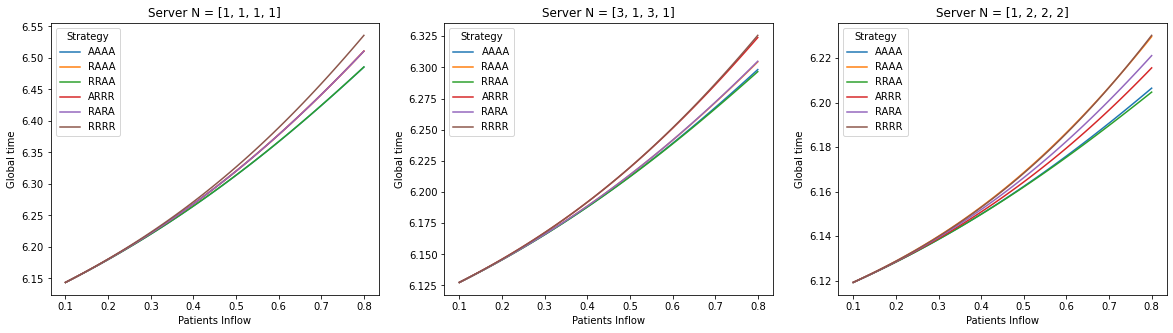

In [18]:
%%time
mu = 0.9
N_lim= 3
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
global_plot([1,1,1,1], axs[0], mu=mu, N_lim=N_lim)
global_plot([3,1,3,1], axs[1], mu=mu, N_lim=N_lim)
global_plot([1,2,2,2], axs[2], mu=mu, N_lim=N_lim)

In [19]:
def global_plot_survival(n, ax, mu=1, N_lim=5, t_c=10):
    data = {
        'Patients Inflow': [],
        'Survival rate': [],
        'Strategy': []
    }
    l_space = np.linspace(0.1, 1, 50)
    for l in l_space:
        hospital = HospitalModel(l, mu, n, N_lim, t_c)
        G = hospital.global_survival_rate()
        data['Patients Inflow'].append(l)
        data['Survival rate'].append(G[0][0][0][0])
        data['Strategy'].append('AAAA')
        #G = hospital.global_average_time_matrix()
        data['Patients Inflow'].append(l)
        data['Survival rate'].append(G[1][0][0][0])
        data['Strategy'].append('RAAA')

        #G = hospital.global_average_time_matrix()
        data['Patients Inflow'].append(l)
        data['Survival rate'].append(G[1][1][0][0])
        data['Strategy'].append('RRAA')
        
        data['Patients Inflow'].append(l)
        data['Survival rate'].append(G[0][1][0][1])
        data['Strategy'].append('ARRR')
        
        data['Patients Inflow'].append(l)
        data['Survival rate'].append(G[1][0][1][0])
        data['Strategy'].append('RARA')
        
        data['Patients Inflow'].append(l)
        data['Survival rate'].append(G[1][1][1][1])
        data['Strategy'].append('RRRR')

        
        
    data = pd.DataFrame(data)
    sns.lineplot(x="Patients Inflow", y="Survival rate", hue="Strategy", data=data, ax=ax)
    ax.set_title('Server N = ' + str(n))

CPU times: user 925 ms, sys: 1.97 ms, total: 927 ms
Wall time: 924 ms


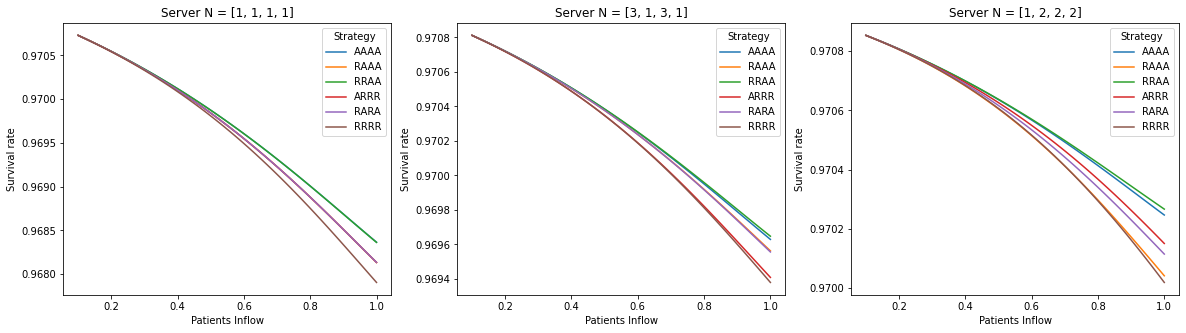

In [20]:
%%time
N_lim= 3
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
global_plot_survival([1,1,1,1], axs[0], mu=mu, N_lim=N_lim)
global_plot_survival([3,1,3,1], axs[1], mu=mu, N_lim=N_lim)
global_plot_survival([1,2,2,2], axs[2], mu=mu, N_lim=N_lim)